In [8]:
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from sklearn import metrics

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

In [9]:
%store -r mc_data

In [10]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xlayer_model = load_model('./models/xlayer_model.h5')

In [11]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        track_classifier = load_model('./models/seed_station_validation_v2.h5')

In [12]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event
14   hasT
15   isInUT
16   isInVelo
17   isLong
18   isLong_fromB
19   isLong_fromB_more5
20   isLong_more5


In [13]:
mc_hits = mc_data.values

In [14]:
%store -r zLays
%store -r max_x
%store -r min_x
%store -r max_y
%store -r min_y
%store -r events

In [15]:
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

In [16]:
event_threshold = 15840

In [17]:
def predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer):
    
    z_stereo = zLays[stereo_layer]
    
    if (stereo_layer % 2 != 0):
        angle = 5
    else:
        angle = -5
        
    if (float(x3 - x0)  == 0):
        m = 1
    else:
        m = float(zLays[last_layer] - zLays[first_layer]) / float(x3 - x0)
    n = zLays[last_layer] - (m * x3)
    
    x_pred = (z_stereo - n) / m 
    beta = (x_pred - x_stereo) / (math.radians(angle) * z_stereo)
    return math.tan(beta) * z_stereo

In [18]:
#
# Test the NN model by using events not feeded as train 
#

def trackReconstruction(hits_total, index_tree):

    # Variables used for calculating metrics
    total_found = 0
    total = 0
    mean_size = np.zeros(3)

    # Variable defining the maximum number of hits gathered from the R-trees when using the predicted value from the NN
    max_hits_gathered = 12

    # Range in which valid hits are look up in the first R-tree
    long_range = 300

    X_classifier = []
    Y_classifier = []

    # For each particle of a given event
    for particle in hits_total:

        # Sometimes there are no PrHits for a given particle, so skip these ones
        if (len(particle[5]) > 1) and (particle[0] != 11) and (particle[0] != -11):

            found_num = 0            
            X_final = {}
            Zone_final = {}
            actual = -1

            # Extract all PrHits
            for i in range(0, len(particle[5])):
                if (actual != particle[8][i]):
                    X_final[particle[8][i]] = []
                    X_final[particle[8][i]].append(particle[5][i])
                    Zone_final[particle[8][i]] = particle[12][i]
                    actual = particle[8][i]
                    found_num += 1
                else:
                    X_final[actual].append(particle[5][i])

            # Check if there are minimum 12 hits found, as for the test, I am only working with complete tracks
            if not 0 in X_final or not 4 in X_final or not 8 in X_final:
                continue

            # List used to iterate over valid height found later on
            valid_y = {}

            # For each station
            for station in range(0,3):

                valid_y[station] = []

                # Compute the layer number based on station
                x0_layer = 0
                if (station == 1):
                    x0_layer = 4
                elif station == 2:
                    x0_layer = 8

                u_layer = x0_layer + 1
                v_layer = x0_layer + 2
                x1_layer = x0_layer + 3

                # Select both the first X position and UP/DOWN based on this
                first_hit = X_final[x0_layer][0]
                zone = Zone_final[x0_layer]

                # Predict all 3 following points based on the first hit selected
                predicted = (xlayer_model.predict(np.array([first_hit, x0_layer]).reshape(1,-1)))[0]
                mean_predicted = ((first_hit + predicted[0] + predicted[1] + predicted[2]) / 4)

                # Recolect all nearest hits from each layer using R-trees based on the X-position of the mean predicted
                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, x1_layer, x1_layer, zone, zone), objects='raw'))
                found_layer3 = sorted(found, key=lambda x: np.abs(x[0]- mean_predicted))[:max_hits_gathered]
                arr_layer3 = np.unique(np.array(found_layer3), axis=0)

                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, v_layer, v_layer, zone, zone), objects='raw'))
                found_layer2 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
                arr_layer2 = np.unique(np.array(found_layer2), axis=0)

                found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, u_layer, u_layer, zone, zone), objects='raw'))
                found_layer1 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
                arr_layer1 = np.unique(np.array(found_layer1), axis=0)

                for h3 in arr_layer3:

                    for h2 in arr_layer2:

                        # Predict height for each hit selected in the V layer
                        pred_h2 = predictHeight(first_hit, h3[0], h2[0], v_layer, x0_layer, x1_layer)

                        if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
                            continue

                        # And for each hit in the V layer, we look up at hits in the U layer with the same height
                        for h1 in arr_layer1:

                            # Predict height for hit in the U layer
                            pred_h1 = predictHeight(first_hit, h3[0], h1[0], u_layer, x0_layer, x1_layer)
                            if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
                                continue

                            if np.abs(pred_h2 - pred_h1) < 26:
                                # Insert into a new R-tree to enable search by height
                                # Store the valid height for later iterate over it
                                valid_y[station].append([first_hit, h1[0], pred_h1, h2[0], pred_h2, h3[0], station, (h1[1],h2[1],h3[1])])
                                
                                found = 0
                                for id in (h1[1],h2[1],h3[1]):
                                    if (id in particle[4]):
                                        found += 1
                                        
                                if (found == 3):
                                    X_classifier.append([first_hit, h1[0], pred_h1, h2[0], pred_h2, h3[0], station])
                                    Y_classifier.append(1)
                                elif (found == 0):
                                    X_classifier.append([first_hit, h1[0], pred_h1, h2[0], pred_h2, h3[0], station])
                                    Y_classifier.append(0)
                            
                            
            total += 1
    #print("\nMean Total Found: %f" % (total_found/total))
    #print("\nMean Size: %f" % (mean_size[0]/total))
    return X_classifier, Y_classifier, total_found/total, mean_size[0]/total
    

In [19]:
mean = size = done = 0
test_events = events[10:310]

X_classifier = []
Y_classifier = []

p = index.Property()
p.dimension = 3
    
for event in test_events:
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    # print("Event length %d " % len(particles_test_event))
    idx = {}
    mean_val = size_val = 0
    index_tree = index.Index(properties=p, interleaved=False)
    for hit in particles_test_event:
        if (len(hit[5]) > 1) and (hit[0] != 11) and (hit[0] != -11):
            for i in range(0,len(hit[5])):
                index_tree.insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), [float(hit[5][i]), int(hit[4][i])])

    X, Y, mean_val, size_val = trackReconstruction(particles_test_event, index_tree)
    
    X_classifier += X
    Y_classifier += Y
    mean += mean_val
    size += size_val
    done += 1
    print("Event %d/%d \t Acc: %f Size %f Proportion %f" % (done,len(test_events), mean_val, size_val, Y.count(0)/(Y.count(1) + 1)))
    
print("\nFinal Result:")
print("\t X_Size : %f" % (len(X_classifier)))
print("\t Y_Size: %f" % (len(Y_classifier)))
print("\t Y count 0 : %f" % (Y_classifier.count(0)))
print("\t Y count 1: %f" % (Y_classifier.count(1)))
print("\t Mean: %f" % (mean/len(test_events)))
print("\t Size: %f" % (size/len(test_events)))

Event 1/300 	 Acc: 0.000000 Size 0.000000 Proportion 0.091743
Event 2/300 	 Acc: 0.000000 Size 0.000000 Proportion 1.162698
Event 3/300 	 Acc: 0.000000 Size 0.000000 Proportion 0.717172
Event 4/300 	 Acc: 0.000000 Size 0.000000 Proportion 0.370732
Event 5/300 	 Acc: 0.000000 Size 0.000000 Proportion 1.464174
Event 6/300 	 Acc: 0.000000 Size 0.000000 Proportion 1.033708
Event 7/300 	 Acc: 0.000000 Size 0.000000 Proportion 1.473171
Event 8/300 	 Acc: 0.000000 Size 0.000000 Proportion 8.111817
Event 9/300 	 Acc: 0.000000 Size 0.000000 Proportion 0.251163
Event 10/300 	 Acc: 0.000000 Size 0.000000 Proportion 5.594915
Event 11/300 	 Acc: 0.000000 Size 0.000000 Proportion 0.871921
Event 12/300 	 Acc: 0.000000 Size 0.000000 Proportion 10.832000
Event 13/300 	 Acc: 0.000000 Size 0.000000 Proportion 2.520089
Event 14/300 	 Acc: 0.000000 Size 0.000000 Proportion 2.168539
Event 15/300 	 Acc: 0.000000 Size 0.000000 Proportion 2.621359
Event 16/300 	 Acc: 0.000000 Size 0.000000 Proportion 14.679739

Event 131/300 	 Acc: 0.000000 Size 0.000000 Proportion 7.015428
Event 132/300 	 Acc: 0.000000 Size 0.000000 Proportion 4.193467
Event 133/300 	 Acc: 0.000000 Size 0.000000 Proportion 9.456885
Event 134/300 	 Acc: 0.000000 Size 0.000000 Proportion 3.109677
Event 135/300 	 Acc: 0.000000 Size 0.000000 Proportion 2.347826
Event 136/300 	 Acc: 0.000000 Size 0.000000 Proportion 3.811209
Event 137/300 	 Acc: 0.000000 Size 0.000000 Proportion 3.467262
Event 138/300 	 Acc: 0.000000 Size 0.000000 Proportion 4.462382
Event 139/300 	 Acc: 0.000000 Size 0.000000 Proportion 1.866873
Event 140/300 	 Acc: 0.000000 Size 0.000000 Proportion 14.351235
Event 141/300 	 Acc: 0.000000 Size 0.000000 Proportion 4.378531
Event 142/300 	 Acc: 0.000000 Size 0.000000 Proportion 4.259058
Event 143/300 	 Acc: 0.000000 Size 0.000000 Proportion 7.878553
Event 144/300 	 Acc: 0.000000 Size 0.000000 Proportion 3.350000
Event 145/300 	 Acc: 0.000000 Size 0.000000 Proportion 7.603359
Event 146/300 	 Acc: 0.000000 Size 0.00

Event 259/300 	 Acc: 0.000000 Size 0.000000 Proportion 8.758993
Event 260/300 	 Acc: 0.000000 Size 0.000000 Proportion 4.057407
Event 261/300 	 Acc: 0.000000 Size 0.000000 Proportion 8.937729
Event 262/300 	 Acc: 0.000000 Size 0.000000 Proportion 6.220539
Event 263/300 	 Acc: 0.000000 Size 0.000000 Proportion 7.513120
Event 264/300 	 Acc: 0.000000 Size 0.000000 Proportion 1.077491
Event 265/300 	 Acc: 0.000000 Size 0.000000 Proportion 6.295181
Event 266/300 	 Acc: 0.000000 Size 0.000000 Proportion 1.487324
Event 267/300 	 Acc: 0.000000 Size 0.000000 Proportion 3.474747
Event 268/300 	 Acc: 0.000000 Size 0.000000 Proportion 0.347561
Event 269/300 	 Acc: 0.000000 Size 0.000000 Proportion 0.242857
Event 270/300 	 Acc: 0.000000 Size 0.000000 Proportion 5.782869
Event 271/300 	 Acc: 0.000000 Size 0.000000 Proportion 2.014652
Event 272/300 	 Acc: 0.000000 Size 0.000000 Proportion 0.691244
Event 273/300 	 Acc: 0.000000 Size 0.000000 Proportion 6.289908
Event 274/300 	 Acc: 0.000000 Size 0.000

In [21]:
final_X_classifier = []
final_Y_classifier = []

for i in range(0, len(Y_classifier)):
    if final_Y_classifier.count(0)/(len(final_Y_classifier) + 1) < 0.6:
        final_X_classifier.append(X_classifier[i])
        final_Y_classifier.append(Y_classifier[i])
    else:
        if Y_classifier[i] == 1:
            final_X_classifier.append(X_classifier[i])
            final_Y_classifier.append(Y_classifier[i])
            

In [22]:
final_Y_classifier.count(0)/len(final_Y_classifier)

0.600001827630112

In [87]:
print(final_X_classifier[200])
print(final_X_classifier[1])
print(final_Y_classifier[200])
print(final_Y_classifier[1])

[-571.0899658203, -578.5525512695, -173.38779368507642, -631.1727905273, -170.76241169202012, -638.8649902344, 1]
[950.7600097656, 911.7686157227, 827.3943278623998, 1089.8713378906, 842.0565580109328, 1049.6099853516, 0]
1
1


In [88]:
track_classifier = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
track_classifier.add(Dense(12, activation='relu', input_dim=7))
track_classifier.add(Dense(8, activation='relu'))
track_classifier.add(Dense(1, activation='sigmoid'))
track_classifier.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
track_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12)                96        
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


In [23]:
X_train, X_test, y_train, y_test = train_test_split(np.array(final_X_classifier), np.array(final_Y_classifier))
print("X Train length: %d" % len(X_train))
print("X Test Length %d" % len(X_test))
print("Y Train length: %d" % len(y_train))
print("Y Test length: %d" % len(y_test))

X Train length: 246220
X Test Length 82074
Y Train length: 246220
Y Test length: 82074


In [92]:
track_classifier.fit(X_train, y_train, epochs=200, batch_size=100, verbose=1, validation_split=0.1)

Train on 143166 samples, validate on 15908 samples
Epoch 1/200
143166/143166 [==============================] - 3s 19us/sample - loss: 0.4387 - acc: 0.8087 - val_loss: 0.4351 - val_acc: 0.8109
Epoch 2/200
143166/143166 [==============================] - 3s 22us/sample - loss: 0.4361 - acc: 0.8112 - val_loss: 0.4298 - val_acc: 0.8177
Epoch 3/200
143166/143166 [==============================] - 4s 26us/sample - loss: 0.4292 - acc: 0.8149 - val_loss: 0.4233 - val_acc: 0.8221
Epoch 4/200
143166/143166 [==============================] - 3s 18us/sample - loss: 0.4278 - acc: 0.8155 - val_loss: 0.4128 - val_acc: 0.8235
Epoch 5/200
143166/143166 [==============================] - 3s 19us/sample - loss: 0.4261 - acc: 0.8167 - val_loss: 0.4104 - val_acc: 0.8291
Epoch 6/200
143166/143166 [==============================] - 3s 21us/sample - loss: 0.4304 - acc: 0.8146 - val_loss: 0.4189 - val_acc: 0.8201
Epoch 7/200
143166/143166 [==============================] - 2s 17us/sample - loss: 0.4250 - acc:

Epoch 58/200
143166/143166 [==============================] - 4s 28us/sample - loss: 0.3637 - acc: 0.8472 - val_loss: 0.3577 - val_acc: 0.8479
Epoch 59/200
143166/143166 [==============================] - 4s 25us/sample - loss: 0.3646 - acc: 0.8467 - val_loss: 0.3517 - val_acc: 0.8499
Epoch 60/200
143166/143166 [==============================] - 4s 30us/sample - loss: 0.3635 - acc: 0.8464 - val_loss: 0.3454 - val_acc: 0.8574
Epoch 61/200
143166/143166 [==============================] - 5s 34us/sample - loss: 0.3628 - acc: 0.8475 - val_loss: 0.3508 - val_acc: 0.8539
Epoch 62/200
143166/143166 [==============================] - 4s 28us/sample - loss: 0.3630 - acc: 0.8466 - val_loss: 0.3474 - val_acc: 0.8525
Epoch 63/200
143166/143166 [==============================] - 3s 21us/sample - loss: 0.3623 - acc: 0.8471 - val_loss: 0.3618 - val_acc: 0.8484
Epoch 64/200
143166/143166 [==============================] - 3s 20us/sample - loss: 0.3628 - acc: 0.8466 - val_loss: 0.3747 - val_acc: 0.8394

Epoch 172/200
143166/143166 [==============================] - 3s 19us/sample - loss: 0.3501 - acc: 0.8522 - val_loss: 0.3490 - val_acc: 0.8532
Epoch 173/200
143166/143166 [==============================] - 3s 20us/sample - loss: 0.3491 - acc: 0.8532 - val_loss: 0.3510 - val_acc: 0.8515
Epoch 174/200
143166/143166 [==============================] - 3s 19us/sample - loss: 0.3496 - acc: 0.8522 - val_loss: 0.3403 - val_acc: 0.8579
Epoch 175/200
143166/143166 [==============================] - 3s 19us/sample - loss: 0.3493 - acc: 0.8525 - val_loss: 0.3357 - val_acc: 0.8621
Epoch 176/200
143166/143166 [==============================] - 3s 19us/sample - loss: 0.3507 - acc: 0.8525 - val_loss: 0.3385 - val_acc: 0.8573
Epoch 177/200
143166/143166 [==============================] - 3s 19us/sample - loss: 0.3502 - acc: 0.8523 - val_loss: 0.3478 - val_acc: 0.8544
Epoch 178/200
143166/143166 [==============================] - 3s 19us/sample - loss: 0.3506 - acc: 0.8527 - val_loss: 0.3485 - val_acc:

In [95]:
score, acc = track_classifier.evaluate(X_test, y_test, batch_size=25)
print('Test score:', score)
print('Test accuracy:', acc)

53025/53025 [==============================] - 2s 39us/sample - loss: 0.3426 - acc: 0.8554
Test score: 0.34256393720256667
Test accuracy: 0.85538894


In [102]:
track_classifier.save("./models/seed_station_validation_v2.h5")

In [24]:
predictions = track_classifier.predict(X_test)

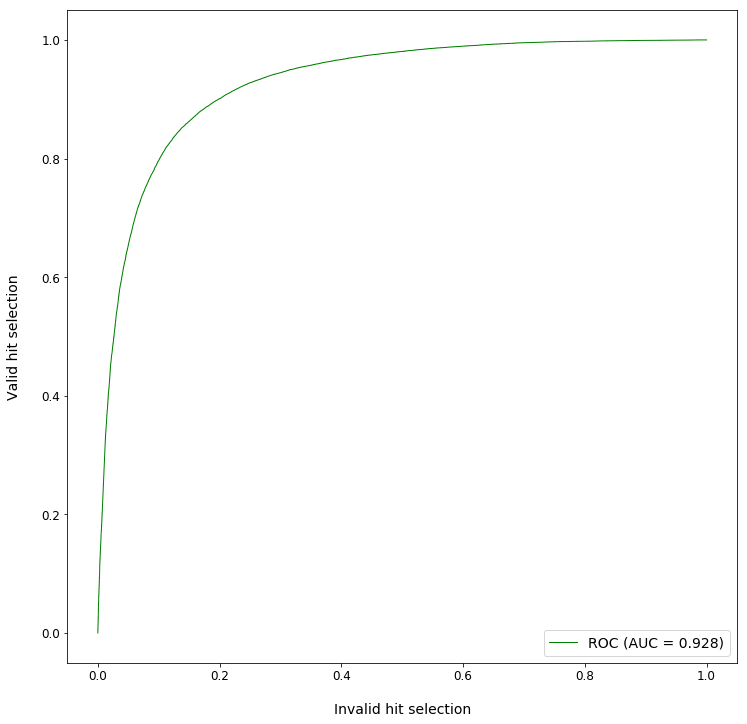

In [26]:
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(12,12))                                        
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC (AUC = %0.3f)' % (roc_auc), c='green')
plt.xlabel('\nInvalid hit selection', fontsize=14)
plt.ylabel('Valid hit selection\n', fontsize=14)
plt.legend(loc = 'lower right',prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

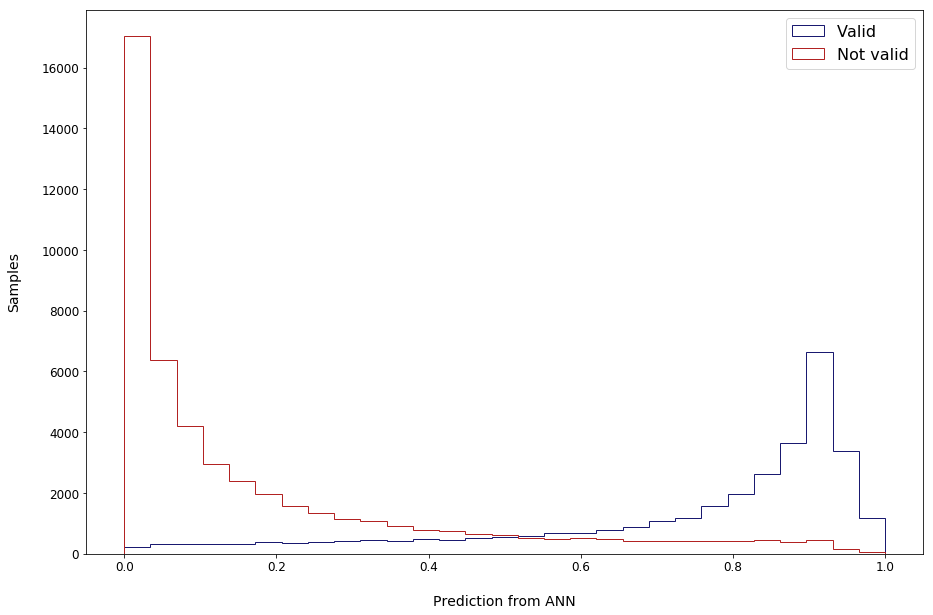

In [27]:
#xgb.plot_importance(booster,grid=True);

fig = plt.figure(figsize=(15,10));
plt.hist(predictions[y_test.reshape(-1).astype(bool)],bins=np.linspace(0,1,30),
         histtype='step',color='midnightblue',label='Valid');
plt.hist(predictions[~(y_test.reshape(-1).astype(bool))],bins=np.linspace(0,1,30),
         histtype='step',color='firebrick',label='Not valid');
# make the plot readable
plt.xlabel('\nPrediction from ANN',fontsize=14);
plt.ylabel('Samples\n',fontsize=14);
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(loc = 'upper right',prop={'size': 16})